# Cross-match RFC_2019d with ZTF_sources

In [1]:
from IPython.core.display import display, HTML, JSON

import tqdm
import pandas as pd
import json
from bson.json_util import loads, dumps
import gzip
import os
import io
from typing import Union
import pathlib
import numpy as np
from astropy.io import fits
from astropy.time import Time
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
from penquins import Kowalski

In [3]:
colors = {1: ['#28a745', '#043927', '#0b6623', '#4F7942',
              '#4CBB17', '#006E51', '#79C753'],
          2: ['#dc3545', '#8d021f', '#FF0800', '#ff2800',
              '#960018', '#FF2400', '#7C0A02'],
          3: ['#343a40', '#343434', '#36454F', '#909090',
              '#536267', '#4C5866', '#9896A4'],
          'zg': ['#28a745', '#0b6623', '#043927', '#4F7942',
                 '#4CBB17', '#006E51', '#79C753'],
          'zr': ['#dc3545', '#8d021f', '#960018', '#ff2800',
                 '#FF0800', '#FF2400', '#7C0A02'],
          'zi': ['#343a40', '#343434', '#36454F', '#909090',
                 '#536267', '#4C5866', '#9896A4'],
          'default': ['#00415a', '#005960', '#20208b']}

def lc_colors(color='default', ind: int = 0):
    if color in colors:
        # re-use if ran out of available colors:
        return colors[color][ind % len(colors[color])]
    else:
        return colors['default'][ind % len(colors['default'])]

In [4]:
t_cut_msip = Time(datetime.datetime(2019, 6, 30, 0)).jd
t_cut_msip

2458664.5

In [5]:
def plot_source(data, time_format='datetime', source_name=None, source_cat='ZTF_sources_20191101'):

    key = list(data[source_cat].keys())[0]
    
    plt.close('all')

    fig_plc = plt.figure(figsize=(10, 4), dpi=200)
    ax_plc = fig_plc.add_subplot(111)
    if source_name:
        ax_plc.title.set_text(f'Photometric light curve for {source_name}')
    else:
        ax_plc.title.set_text(f'Photometric light curve for {key}')

    lc_color_indexes = dict()

    for source in data[source_cat][key]:
        filt = source['filter']
        lc_color_indexes[filt] = lc_color_indexes[filt] + 1 if filt in lc_color_indexes else 0
        c = lc_colors(filt, lc_color_indexes[filt])

        df_plc = pd.DataFrame.from_records(source['data'])
        # display(df_plc)
        
        df_plc['mjd'] = df_plc.hjd - 2400000.5

        df_plc['datetime'] = df_plc['mjd'].apply(lambda x: Time(x, format='mjd').datetime)
        # strings for plotly:
        df_plc['dt'] = df_plc['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

        df_plc.sort_values(by=['mjd'], inplace=True)

        # fractional days ago
        df_plc['days_ago'] = df_plc['datetime'].apply(lambda x: 
                                                      (datetime.datetime.utcnow() - 
                                                       x).total_seconds() / 86400.)

        # filter out unreleased MSIP data or only use it for QA
        # w_msip = (df_plc['programid'] != 1) | (df_plc['hjd'] <= t_cut_msip)
        w_msip = (df_plc['programid'] == 1) & (df_plc['hjd'] <= t_cut_msip)

        w_good = w_msip & (df_plc['catflags'] == 0)
        if np.sum(w_good) > 0:
            t = df_plc.loc[w_good, time_format]
            mag = df_plc.loc[w_good, 'mag']
            mag_error = df_plc.loc[w_good, 'magerr']

            ax_plc.errorbar(t, mag, yerr=mag_error, elinewidth=0.4, 
                            marker='.', c=c, lw=0, label=f'filter: {filt}')

        w_not_so_good = w_msip & (df_plc['catflags'] != 0)
        if np.sum(w_not_so_good) > 0:
            t = df_plc.loc[w_not_so_good, time_format]
            mag = df_plc.loc[w_not_so_good, 'mag']
            mag_error = df_plc.loc[w_not_so_good, 'magerr']

            ax_plc.errorbar(t, mag, yerr=mag_error, elinewidth=0.4, 
                            marker='x', alpha=0.5, c=c, lw=0, label=f'filter: {filt}, flagged')

    ax_plc.invert_yaxis()
    # if t_format == 'days_ago':
    #     ax_plc.invert_xaxis()
    ax_plc.grid(True, lw=0.3)
    # ax_plc.set_xlabel(t_format)
    ax_plc.set_ylabel('mag')
    ax_plc.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize='x-small')
    plt.show()

Connect to Kowalski:

In [6]:
with open('secrets_penquins.json', 'r') as f:
    secrets = json.load(f)

k = Kowalski(username=secrets['kowalski']['username'], password=secrets['kowalski']['password'])

connection_ok = k.check_connection()
print(f'Connection OK: {connection_ok}')

Connection OK: True


## Cross-match

Find out the current YYYYMMDD time tag for the `ZTF_sources` catalog:

In [7]:
q = {"query_type": "info",
     "query": {
         "command": "catalog_names"
     }
     }
r = k.query(query=q)
catalog_names = [cn for cn in r['result_data']['query_result'] 
                 if ('ZTF_sources' in cn) or ('ZTF_exposures' in cn)]
display(catalog_names)
t_tag = catalog_names[0].split('_')[2]
display(t_tag)

source_cat = f"ZTF_sources_{t_tag}"

['ZTF_sources_20191101', 'ZTF_exposures_20191101']

'20191101'

Get `RFC_2019d` source ra/decs:

In [8]:
rfc_cat = 'RFC_2019d'

q = {"query_type": "find",
     "query": {
         "catalog": rfc_cat,
         "filter": {},
         "projection": {"_id": 1, "ra": 1, "dec": 1}
     }}
r = k.query(query=q)

rfc_sources = r['result_data']['query_result']

In [9]:
df = pd.DataFrame.from_records(rfc_sources, columns=['_id', 'ra', 'dec'])
df['got_data'] = False
df.head(5)

,_id,ra,dec,got_data
0,J0000-1352,0.013018,-13.866876,False
1,J0000+0816,0.029296,8.279181,False
2,J0000-3738,0.035059,-37.639076,False
3,J0000+0248,0.080343,2.804080,False
4,J0000+1139,0.081516,11.655758,False


J0000-1352


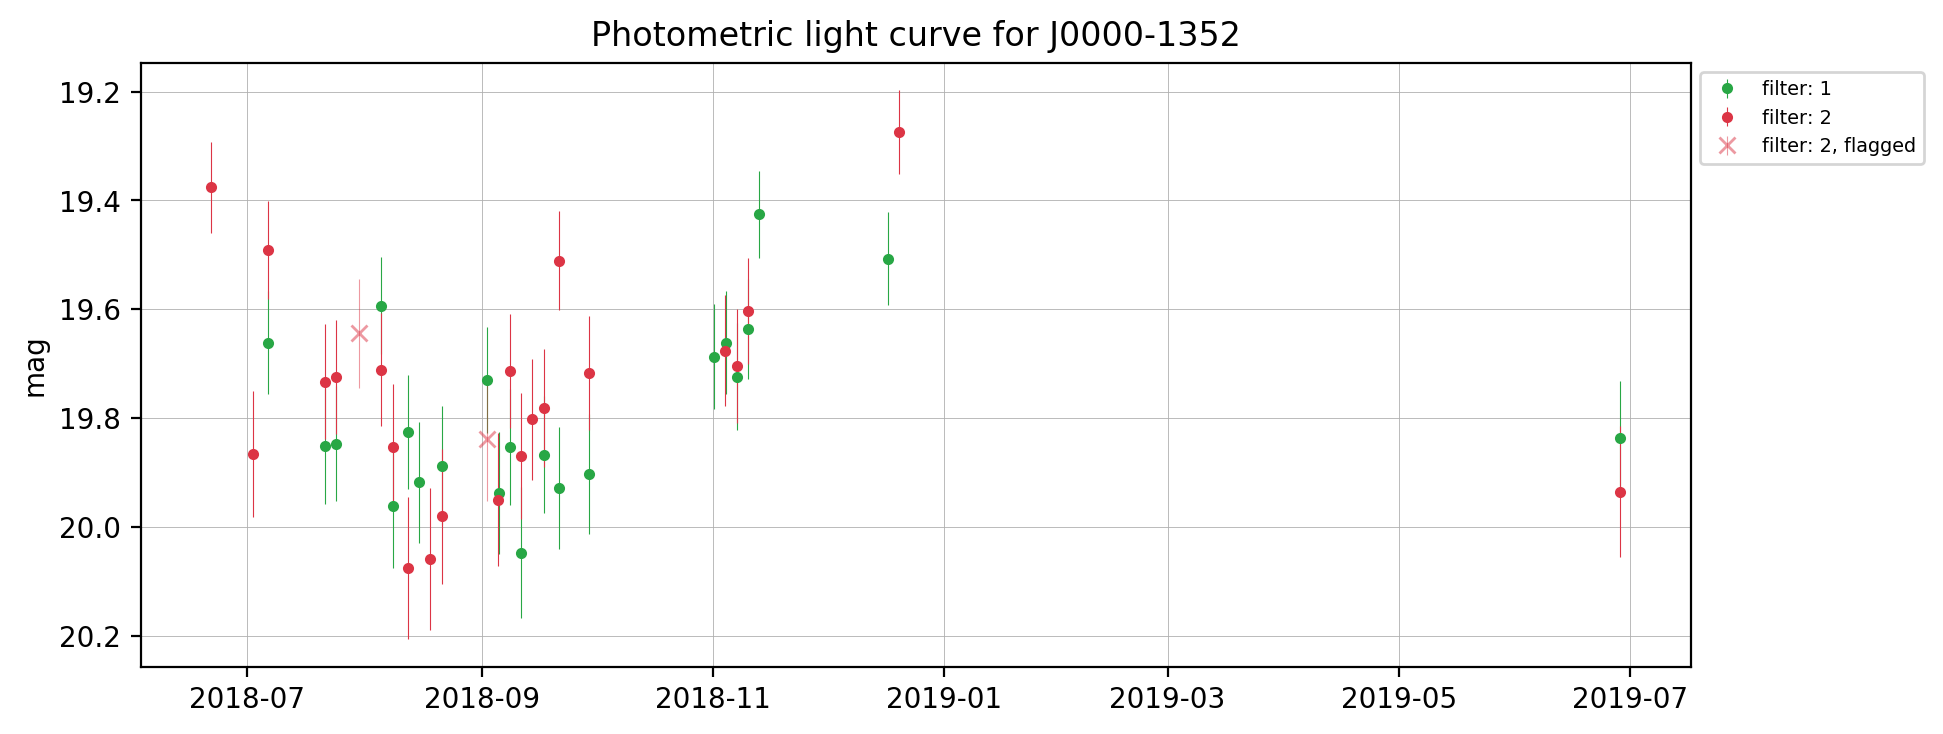

J0000+0816


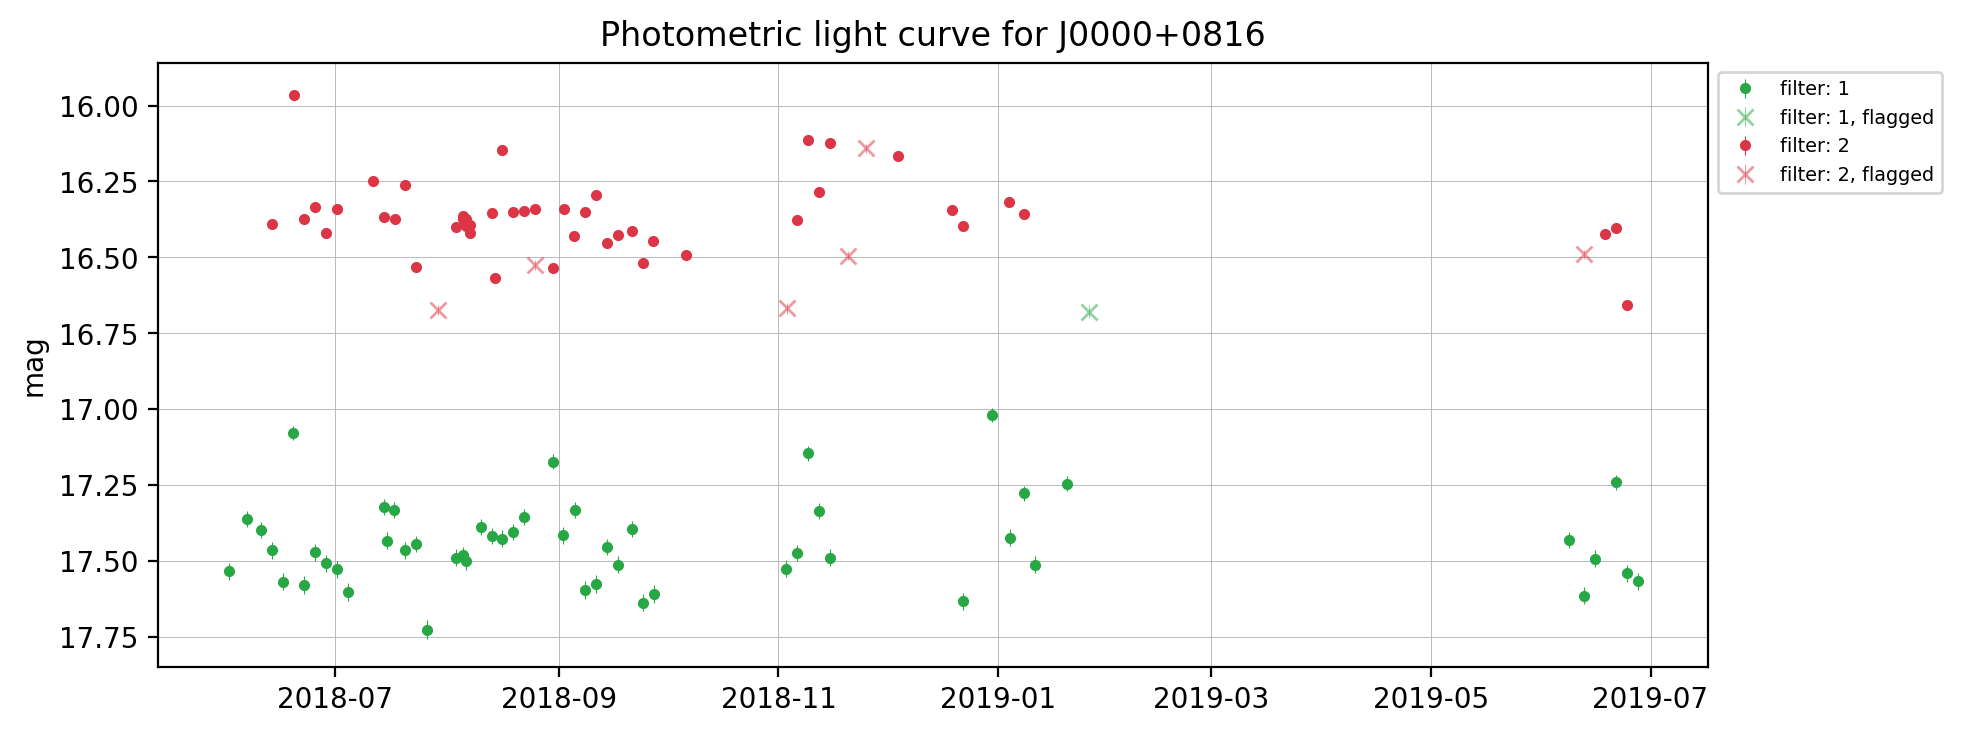

J0000-3738
No ZTF data


In [12]:
for ir, rfc_source in df.head(3).iterrows():
    print(rfc_source._id)
    q = {"query_type": "cone_search",
         "object_coordinates": {
             "radec": f"[({rfc_source.ra}, {rfc_source.dec})]",
             "cone_search_radius": "2",
             "cone_search_unit": "arcsec"
         },
         "catalogs": {
             source_cat: {
                 "filter": {},
                 "projection": {}
             }
         }
         }
    r = k.query(query=q)
    data = r['result_data']

    key = list(data[source_cat].keys())[0]
    got_data = True if len(data[source_cat][key]) > 0 else False
    
    df.loc[ir, 'got_data'] = got_data
    
    if got_data:
        plot_source(data, source_name=rfc_source._id, source_cat=source_cat)
    else:
        print('No ZTF data')
    
#     if ir == 7:
#         break

In [11]:
print(f"Got public ZTF data for {df['got_data'].sum()} sources out of {len(df)} in {rfc_cat}")

Got public ZTF data for 5 sources out of 16723 in RFC_2019d
